In [18]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')

# Connecting to the dataset
The dataset was downloaded here https://www.kaggle.com/nolanbconaway/pitchfork-data. The link provides more information on the dataset and it's tables

In [2]:
con = sqlite3.connect('database.sqlite')

In [8]:
query = """
   SELECT r.reviewid, 
          title, 
          artist, 
          year, 
          score, 
          best_new_music, 
          pub_date, 
          pub_year, 
          genre, 
          label
     FROM reviews r
LEFT JOIN genres g  
       ON r.reviewid = g.reviewid
LEFT JOIN labels l 
       ON r.reviewid = l.reviewid
LEFT JOIN years y 
       ON r.reviewid = y.reviewid
       """

df = pd.read_sql_query(query, con)

## Exploration of the data set
The analysis we want to run will be around the a potential bias pitchfork has towards any particular genres.<br>
The questions we want to ask ourselves are: <br>
_"What genre does Pitchfork review the most"_<br>_"What genre does Pitchfork review the highest"_<br>
We'll only need a specific subset of columns for this.

In [9]:
#Selecting relevant columns and visualizing first rows
df = df[['reviewid','score','best_new_music','pub_year','genre']]
df.head()

,reviewid,score,best_new_music,pub_year,genre
0,22703,9.3,0,2017,electronic
1,22721,7.9,0,2017,metal
2,22659,7.3,0,2017,rock
3,22659,7.3,0,2017,rock
4,22661,9.0,1,2017,rock


In [10]:
#Checking for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25922 entries, 0 to 25921
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewid        25922 non-null  int64  
 1   score           25922 non-null  float64
 2   best_new_music  25922 non-null  int64  
 3   pub_year        25922 non-null  int64  
 4   genre           23269 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 1012.7+ KB


In [11]:
#Seems like the genre column has some missing values, let's drop them
df.dropna(subset=['genre'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23269 entries, 0 to 25920
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewid        23269 non-null  int64  
 1   score           23269 non-null  float64
 2   best_new_music  23269 non-null  int64  
 3   pub_year        23269 non-null  int64  
 4   genre           23269 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 1.1+ MB


In [13]:
#since we'll want to run analysis of reviews throughout the years, let's check whether all years have enough data
df.pub_year.value_counts()

2007    1631
2006    1627
2008    1620
2011    1619
2016    1572
2010    1568
2005    1550
2009    1526
2004    1488
2012    1386
2003    1374
2015    1320
2013    1257
2014    1199
2002    1133
2001     582
2000     470
1999     329
2017      18
Name: pub_year, dtype: int64

In [14]:
#seems like we can drop 2017 which only has 18 reviews
df = df[df.pub_year < 2017] 

## Data Modeling & Results
Now that the data is ready, we can transform it in a way that makes it easy for us to answer the business questions we have. <br>
The dataset is at the individual review level, we want to aggregate it across the review years and the genres, aggregating the relevant metrics.

In [15]:
#group by the relevant columns and aggregate the metrics we're interested in
df_genre_year = (
    df.groupby(['pub_year','genre'])
    #we take the mean of the score (since it's at review level we don't have to weight it)
    #the count of the reviews to get the total number of reviews per year and genre
    #and the mean of the best_new_music column which was a binary column, hence returning its frequency 
    .agg({'score':'mean', 'reviewid':'count', 'best_new_music':'mean'})
    .reset_index()
    .sort_values(by=['pub_year','genre'])
)

#let's rename the reviewid column to something more relatable
df_genre_year.rename(columns={'reviewid':'n_of_reviews'}, inplace=True)

#visualize first rows
df_genre_year.head()

,pub_year,genre,score,n_of_reviews,best_new_music
0,1999,electronic,6.850000,94,0.0
1,1999,experimental,6.584375,32,0.0
2,1999,folk/country,7.766667,6,0.0
3,1999,global,8.433333,3,0.0
4,1999,jazz,7.558333,12,0.0


Let's visualize the first question we had <br>
_"Is there a genre Pitchfork reviews the most?"_

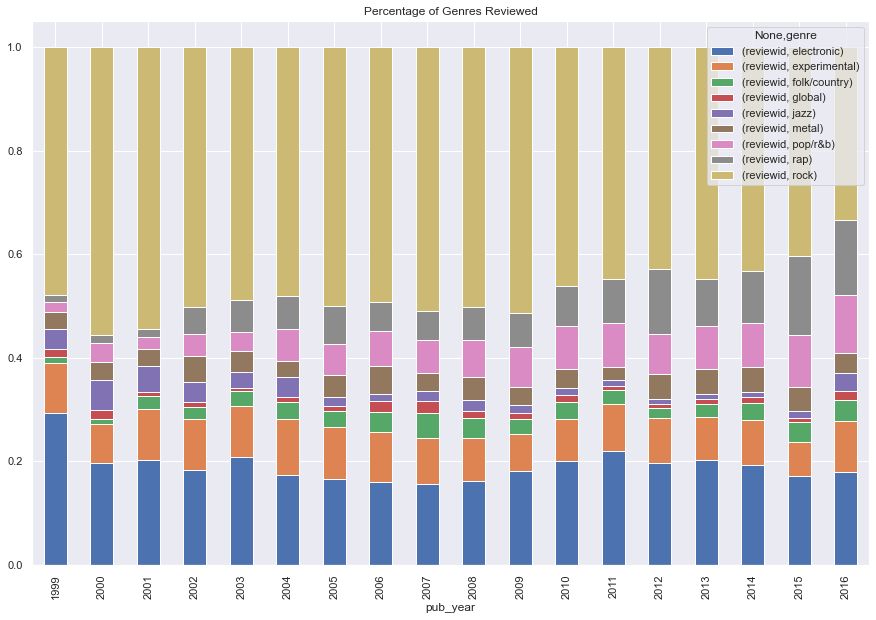

In [22]:
#We have to pivot the table in order to get a 100% stacked chart of the different genres per year 
perc_values = df.pivot_table(
    values=['reviewid'], 
    index='pub_year',
    columns='genre', 
    aggfunc='sum'
)
perc_values = tps.div(tps.sum(1), axis=0)

#plotting stacked column to get a sense of the relative development of the genres reviewed
perc_values.plot(kind='bar', stacked=True, title='Percentage of Genres Reviewed', figsize=(15,10));

Seems like Rock and Electronic are the two genres Pitchfork reviews the most, with Rap becoming a popular one in most recent years! <br>
Let's now see if there are any differences across the scores.

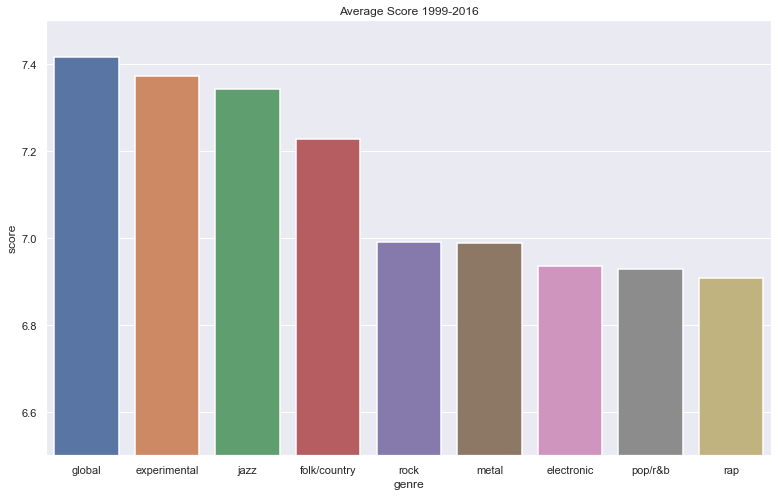

In [24]:
#Let's group by genre and avreage out the results across all the years
data = df.groupby('genre')['score'].mean().reset_index().sort_values(by='score', ascending=False)

#We use seaborn to plot the data
sns.barplot(data=data, x='genre', y='score', linewidth=1.5,).set_title('Average Score 1999-2016')

#zooming in so the differences are clearer
plt.ylim(6.5,7.5)

#making the plot bigger
sns.set(rc={'figure.figsize':(13,8)});

Seems like Global, Experimental, Jazz and Folk/Country are the most favoured by the website, scoring consistently higher than the other genres. <br> 
Another thing we could look at is the frequency with which an album is labeled as Best New Music

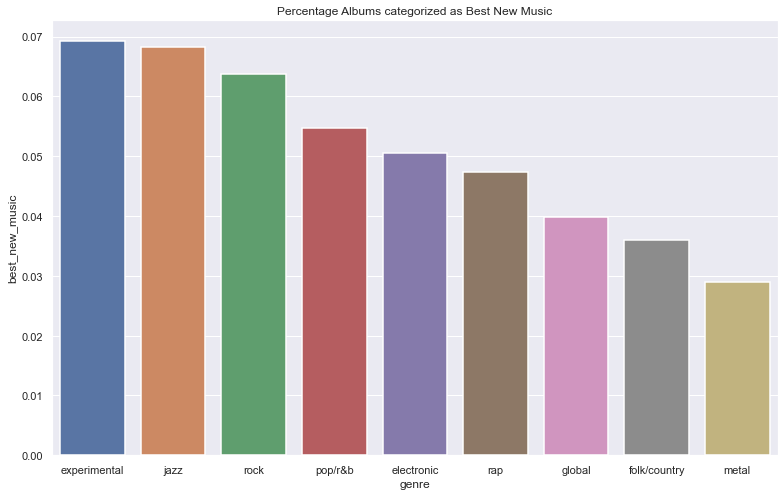

In [25]:
#The best new music column is a binary for each album row. By taking the mean we directly compute the frequency!
data = df_genre_year.groupby('genre')['best_new_music'].mean().reset_index().sort_values(by='best_new_music', ascending=False)

#visualizing the results
sns.barplot(data=data, x='genre', y='best_new_music', linewidth=1.5).set_title('Percentage Albums categorized as Best New Music')

#setting figure size
sns.set(rc={'figure.figsize':(13,8)});

Interestingly enough, we see the Experimental genre at the top of this list as well. Seems like Pitchfork might have a penchant for this particular genre... <br>
Here's the link to the complete analysis! <br>
https://alessandro-vitelli.medium.com/are-pitchfork-reviews-biased-towards-a-specific-genre-be28c74e3de6